## Non-Gaussian mass function
Following from the formalism in [Fiorino et al. (2024)](https://arxiv.org/abs/2410.21457v1), including computing the mass variance from the integral
$$
\sigma_M^2 = \langle \delta^2(R)\rangle \equiv \langle \delta_R^2(\mathbf{x})\rangle = \int \frac{d^3k}{(2\pi)^3}\hat{\mathcal{M}}^2_R(k)P_\Phi(k) = \frac{1}{2\pi^2} \int dk \, k^2 \hat{\mathcal{M}}^2_R(k)P_\Phi(k)
$$

and comparing with the fitting function in [Ludlow et al. (2016)](https://arxiv.org/abs/1601.02624)
$$
\sigma^2_M \equiv \sigma^2(M,z) = \left[D(z)\frac{22.26\,\xi^{0.292}}{1+1.53\,\xi^{0.275}+3.36\,\xi^{0.198}}\right]^2
$$

In [1]:
from sashimi_c import *
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import matplotlib.pyplot as plt

In [ ]:
# Set up
sh = halo_model()

# Define the units
unit_k = sh.h / sh.Mpc
unit_r = sh.Mpc / sh.h

### 1. Compute the normalised skewness $S_3$
From eq.2.14 in https://arxiv.org/pdf/2410.21457, the empirical relation for $S_3$ is defined as:

$$
S_3 \simeq f_{NL}\frac{\alpha}{\sigma_M^{2\beta}}
$$

where $\alpha = 2.16 \times 10^{-4}$, $\beta = 0.4$, $\gamma = 8.43 \times 10^{-8}$, and $\sigma_M^2$ is the mass variance evaluated at $z=0$ on a scale $R$ corresponding to the mass $M$, where

$$
\sigma_M^2 = \langle \delta^2(R)\rangle \equiv \langle \delta_R^2(\mathbf{x})\rangle = \int \frac{d^3k}{(2\pi)^3}\hat{\mathcal{M}}^2_R(k)P_\Phi(k) = \frac{1}{2\pi^2} \int dk \, k^2 \hat{\mathcal{M}}^2_R(k)P_\Phi(k)
$$

and in general for two different smoothing scales $R_1$ and $R_2$,

$$
\langle \delta(R_1)\delta(R_2)\rangle \equiv \langle \delta_{R_1}(\mathbf{x})\delta_{R_2}(\mathbf{x})\rangle = \frac{1}{2\pi^2} \int dk \, k^2 \hat{\mathcal{M}}_{R_1}(k)\hat{\mathcal{M}}_{R_1}(k)P_\Phi(k)
$$

where $\hat{\mathcal{M}}_{R}(k) = \hat{\mathcal{M}}_{R}(k,z,R)$ (defined as `M_smoothed(k,z,R)` in the code) is given by
$$
\hat{\mathcal{M}}_{R}(k) = \hat{\mathcal{M}}_{R}(k,z,R) = \mathcal{M}(k,z)\hat{W}(k,R) = \frac{2c^2k^2\,T(k)D(z)}{3\Omega_mH_0^2}\frac{3}{(kR)^3}\Bigl[\,\text{sin}(kR)-kR\,\text{cos}(kR)\,\Bigr] 
$$

and the power spectrum is given by https://arxiv.org/abs/1106.4404:
$$
P_\Phi(k) = \frac{2\pi^2}{k^3} A_\text{s}\left(\frac{k}{k_*}\right)^{n_\text{s}-1}
$$
where $k_* = 0.05 \text{Mpc}^{-1}$, $A_s=3.0488$, $n_s=0.96605$ are taken from https://arxiv.org/pdf/1807.06211.

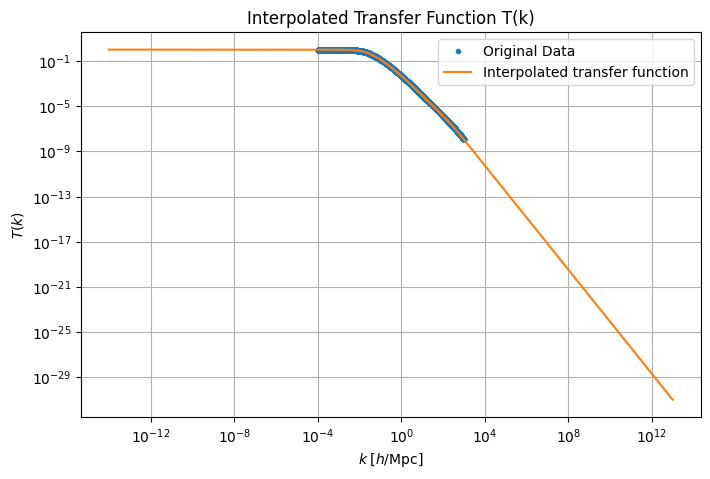

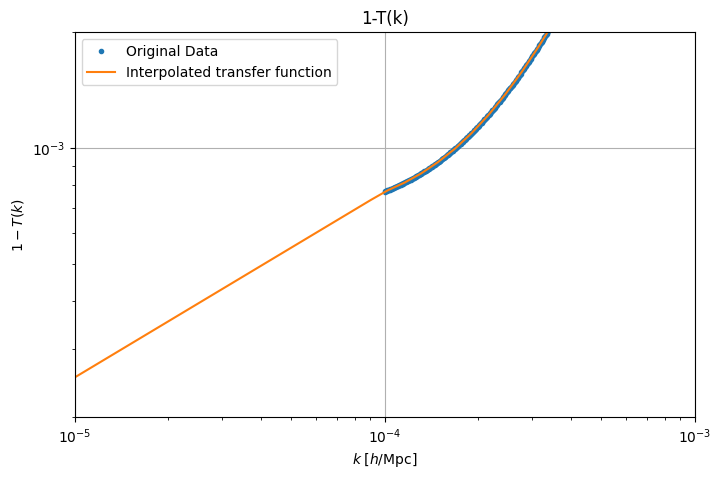

In [36]:
# Define T(k):
# Load the transfer function data from Tk_CLASS.txt as an interpolated function
# The file contains two columns: the first column is k values (h/Mpc) and the second column is the transfer function T(k)

# Notes from the file:
# CLASS transfer function for vanilla LCDM with 3 massless neutrinos
# Cosmo parameters taken from first column in Table 1 of arxiv:1807.06209
    # omega_b * (h^2) = 0.022383
    # omega_cdm * (h^2) = 0.12011
    # h = 0.6732
    # ln(10^{10} * A_s) = 3.0448
    # n_s = 0.96605

# Load the transfer function data from Tk_CLASS.txt
data = np.loadtxt('Tk_CLASS.txt')
# Extract the k values and T(k) values from the two columns
k_data = data[:,0] * unit_k   # k values (h/Mpc)
Tk_data = data[:,1]     # Transfer function T(k)

# Create the interpolation function T(k)
# transfer_function = interp1d(k_data, Tk_data, kind='linear', bounds_error=False, fill_value="extrapolate")
_transfer_function = interp1d(np.log10(k_data), np.log10(Tk_data), kind='linear', bounds_error=False, fill_value="extrapolate")
_1mtransfer_function = interp1d(np.log10(k_data), np.log10(1-Tk_data), kind='linear', bounds_error=False, fill_value="extrapolate")
# transfer_function = lambda k: 10**_transfer_function(np.log10(k))
transfer_function = lambda k: np.where(k>1e-2*unit_k, 10**_transfer_function(np.log10(k)), 1 - 10**_1mtransfer_function(np.log10(k)))

# Example: evaluate the function at some points
k_eval = np.logspace(np.log10(min(k_data))-10, np.log10(max(k_data))+10, 500)
Tk_eval = np.abs(transfer_function(k_eval))

# Optional: plot to check
plt.figure(figsize=(8, 5))
plt.loglog(k_data/unit_k, Tk_data, '.', label='Original Data')
plt.loglog(k_eval/unit_k, Tk_eval, '-', label='Interpolated transfer function')
plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
plt.ylabel(r'$T(k)$')
plt.legend()
plt.grid()
plt.title('Interpolated Transfer Function T(k)')
plt.show()

# Optional: plot to check
plt.figure(figsize=(8, 5))
plt.loglog(k_data/unit_k, 1-Tk_data, '.', label='Original Data')
plt.loglog(k_eval/unit_k, 1-Tk_eval, '-', label='Interpolated transfer function')
plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
plt.ylabel(r'$1-T(k)$')
plt.xlim(1e-5,1e-3)
plt.ylim(2e-4,2e-3)
plt.legend()
plt.grid()
plt.title('1-T(k)')
plt.show()

In [37]:
# Define the function M(k,z)
def M_transfer(k,z):
    """
    Define the dimensionless function M(k,z) that connects the gravitational potential to the matter density field (in Fourier space):
        M(k,z) = 2 * c^2 * k^2 * T(k) * D(z) / (3 * OmegaM * H0^2)
    where:
        c = speed of light (in Mpc/s), from sashimi_c
        k = wavenumber (in h/Mpc, where h is the dimensionless reduced Hubble parameter)
        T(k) = transfer function (dimensionless), from Tk_CLASS.txt
        D(z) = growth factor at redshift z (dimensionless), from sashimi_c
        H0 = (present day) Hubble constant (in s^{-1}), from sashimi_c
        OmegaM = matter density parameter (dimensionless), from sashimi_c
    """
    #return 2 * (sh.c**2) * k**2 * transfer_function(k) * sh.growthD(z) / (3 * sh.OmegaM * sh.H0**2)
    return 2 * pow(sh.c,2) * pow(k,2) * transfer_function(k) * sh.growthD(z) / (3 * sh.OmegaM * pow(sh.H0,2))

def M(k,z):
    return 2 * (sh.c**2) * k**2 * transfer_function(k) * sh.growthD(z) / (3 * sh.OmegaM * sh.H0**2)

# Define the window function W(k,R)
# Write this into a function of M instead of R
def Window_func(k,z,M):
    """
    Define the Fourier space window function W(k,R) for a spherical top-hat filter function in real space:
        W(k,R) = 3 * (sin(kR) - kR * cos(kR)) / (kR)^3 = 3 * j_1(kR) / (kR)
    where:
        k = wavenumber (in h/Mpc, array_like or float)
        R = smoothing scale (in Mpc/h, float)
        j_1 is spherical Bessel function of the first kind of order 1
    """
    R = pow(3 * M / (4 * np.pi * sh.OmegaM * sh.rhocrit0 * pow(1+z,3)), 1/3)  # Convert M to R using the mass density relation
    # Use np.where to safely handle k = 0
    # return np.where(k == 0.0, 1.0, 3 * spherical_jn(1, k*R) / (k*R))
    return np.where(k == 0.0, 1.0, 3 * (np.sin(k*R) - k*R*np.cos(k*R)) / (k*R)**3)

def W(k,R):
    return np.where(k == 0.0, 1.0, 3 * spherical_jn(1, k*R) / (k*R))

# Define the function M_smoothed(k,z,R)
def M_smoothed(k,z,M):
    """
    Define the function M_smoothed(k,z,R), i.e. M(k,z) smoothed by the window function W(k,R):
        M_smoothed(k,z,R) = M(k,z) * W(k,R)
    where M(k,z) and W(k,R) are defined as above.
    This function computes the smoothed version of M(k,z) by multiplying it with the window function W(k,R).
    """
    return M_transfer(k,z) * Window_func(k,z,M)

def M_smoothed_original(k,z,R):
    return M(k,z) * W(k,R)

In [38]:
# Define the power spectrum P_Phi(k):
def P_Phi(k):
    """
    Define the power spectrum P_Phi(k,z) of the gravitational potential:
        P_Phi(k) = A_s * (k/k*)^(n_s - 4)
    where:
        k = wavenumber (in h/Mpc, array_like or float)
        A_s = amplitude of the primordial power spectrum
        n_s = 0.96605 is the scalar spectral index
        k_ref = pivot scale (in h/Mpc, typically chosen to be 0.05 Mpc^{-1})
    """
    # Define the constants (from Table 1 of arxiv:1807.06209)
    A_s = np.exp(3.0448) / 1e10   # since ln(10^{10} * A_s) = 3.0448
    n_s = 0.96605
    k_ref = 0.05 * (sh.Mpc**-1)  # pivot scale in 1/Mpc
    #return A_s * (k/k_ref)**(n_s - 4) # definition from arXiv:2410.21457
    return 2 * np.pi**2 * k**-3 * A_s * (k/k_ref)**(n_s - 1) # definition from arXiv:1103.2586, this significantly improves the results

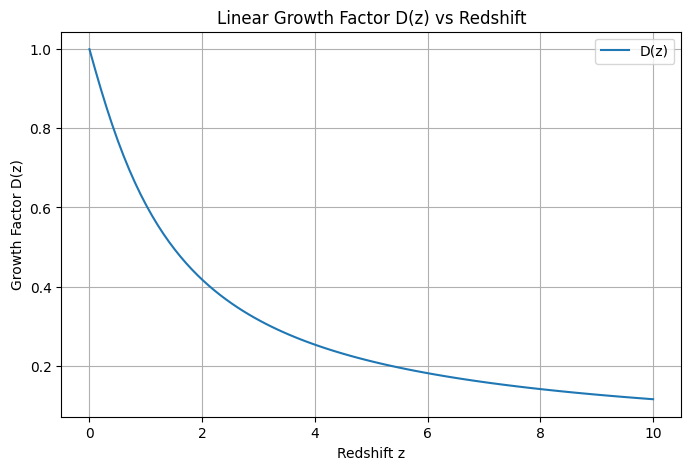

In [6]:
# test: plot the linear growth factor D(z) for a range of redshifts
z_values = np.linspace(0, 10, 100)
D_values = sh.growthD(z_values)

plt.figure(figsize=(8, 5))
plt.plot(z_values, D_values, label='D(z)')
plt.xlabel('Redshift z')
plt.ylabel('Growth Factor D(z)')
plt.title('Linear Growth Factor D(z) vs Redshift')
plt.grid()
plt.legend()
plt.show()

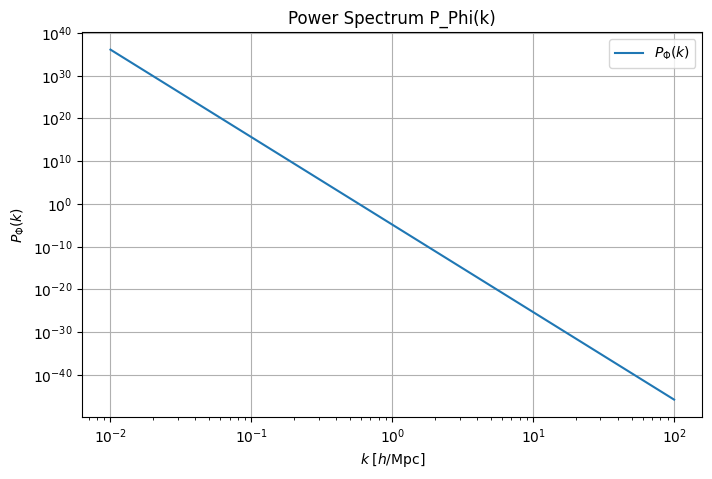

In [7]:
# plot the power spectrum P_Phi(k)
k_values = np.logspace(-2, 2, 500)  # k values for plotting
P_Phi_values = P_Phi(k_eval * unit_k)  # Calculate P_Phi for the k values
plt.figure(figsize=(8, 5))
plt.loglog(k_values, P_Phi_values, '-', label=r'$P_\Phi(k)$')
plt.xlabel(r'$k \; [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_\Phi(k)$')
plt.title('Power Spectrum P_Phi(k)')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Define the 2-point function (and hence the mass variance with R1=R2=R, z=0.)

def compute_2pt_fct(M1, M2, z):
    """
    Compute the two-point correlator ⟨δ(R₁)δ(R₂)⟩ from one term in the bispectrum 
    using a two-dimensional integration via scipy.integrate.nquad.

    The expression computed is for:
         ⟨δ(R₁)δ(R₂)⟩ = 1/(2π^2) ∫₀^∞ dk k^2 * M_smoothed(k,z,R₁) * M_smoothed(k,z,R₂) * P_Phi(k)
    where:
        k = wavenumber (in h/Mpc)
        M_smoothed(k,z,R) = M(k,z) * W(k,R)
        P_Phi(k) = A_s * (k/k_ref)^(n_s - 4)
    The prefactor 1/(2π^2) comes from the integration over k in two dimensions.
    
    Parameters:
        M1, M2: masses associated with smoothing scales R1 and R2.
        z: redshift.
        
    Returns:
        The value of the two-point correlator.
    """
    def _single(M1_single, M2_single):
        prefactor = 1 / (2 * np.pi**2)
        def integrand(k):
            return k**2 * M_smoothed(k, z, M1_single) * M_smoothed(k, z, M2_single) * P_Phi(k)
        result, err = quad(integrand, 0, np.inf, epsabs=1e-6)
        return prefactor * result

    # Use np.vectorize to handle arrays or scalars
    vectorized = np.vectorize(_single)
    return vectorized(M1, M2)

def compute_2pt_fct_original(R1, R2, z):
    def _single(R1_single, R2_single):
        prefactor = 1 / (2 * np.pi**2)
        def integrand(k):
            return k**2 * M_smoothed_original(k, z, R1_single) * M_smoothed_original(k, z, R2_single) * P_Phi(k)
        result, err = quad(integrand, 0, np.inf, epsabs=1e-6)
        return prefactor * result
    # Use np.vectorize to handle arrays or scalars
    vectorized = np.vectorize(_single)
    return vectorized(R1, R2)

/tmp/ipykernel_335917/615439473.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, err = quad(integrand, 0, np.inf, epsabs=1e-6)
/tmp/ipykernel_335917/615439473.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, err = quad(integrand, 0, np.inf, epsabs=1e-6)


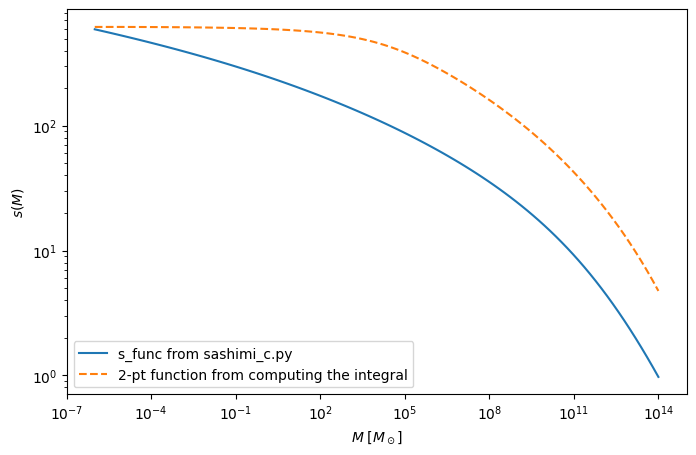

In [9]:
# compare compute_2pt_fct with s_func(M) in sashimi_c.py
M_eval = np.logspace(-6, 14, 100)  # Msun
s_func_eval = sh.s_func(M_eval)
twopt_func_eval = compute_2pt_fct(M_eval, M_eval, z=0)
plt.figure(figsize=(8, 5))
plt.loglog(M_eval, s_func_eval, '-', label='s_func from sashimi_c.py')
plt.loglog(M_eval, twopt_func_eval, '--', label='2-pt function from computing the integral')
plt.xlabel(r'$M \; [M_\odot]$')
plt.ylabel(r'$s(M)$')
plt.legend()

/tmp/ipykernel_335917/2459955291.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, err = quad(integrand, 0, np.inf, epsabs=1e-6)
/tmp/ipykernel_335917/2459955291.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, err = quad(integrand, 0, np.inf, epsabs=1e-6)


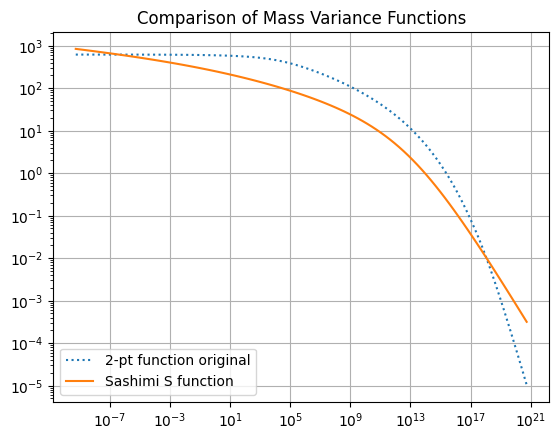

In [33]:
R = np.logspace(-7, 3, 100) * unit_r  # Mpc/h
Mass = (4/3) * np.pi * (R**3) * sh.OmegaM * sh.rhocrit0  # Convert R to M using the mass density relation
m_unit = sh.Msun
twopt_func_eval_original = compute_2pt_fct_original(R, R, z=0)
sashimi_s_func_eval = sh.s_func(Mass)
plt.loglog(Mass/m_unit, twopt_func_eval_original, ':', label='2-pt function original')
plt.loglog(Mass/m_unit, sashimi_s_func_eval, '-', label='Sashimi S function')
plt.legend()
plt.title('Comparison of Mass Variance Functions')
plt.grid()
plt.show()

In [10]:
# Define S_3 using the fitting function for s_func from Ludlow et al. (2016)
def S3_fit(f_NL, M):
    """
    Compute the fitting function for S_3 = <δ(R)^3>/<δ(R)^2>^2 using the empirical relation:
        S_3 \simeq f_NL * alpha / (sigma^2)^beta
    where:
        alpha = 2.16e-4
        beta = 0.4
        sigma^2 = compute_2pt_fct(R1=R, R2=R, z=0.0)
    
    Parameters:
        f_NL: non-Gaussianity parameter.
        R: smoothing scale (in Mpc/h).
        
    Returns:
        The value of the fitting function for S_3.
    """
    alpha = 2.16e-4
    beta = 0.4
    #sigma2 = compute_2pt_fct(M1=M, M2=M, z=0.0)
    sigma2 = sh.s_func(M)
    return f_NL * alpha / sigma2**beta

In [11]:
# Previously, define S_3 using with the compute_2pt_fct
def S3_int(f_NL, M):
    """
    Compute the fitting function for S_3 = <δ(R)^3>/<δ(R)^2>^2 using the empirical relation:
        S_3 \simeq f_NL * alpha / (sigma^2)^beta
    where:
        alpha = 2.16e-4
        beta = 0.4
        sigma^2 = compute_2pt_fct(R1=R, R2=R, z=0.0)
    
    Parameters:
        f_NL: non-Gaussianity parameter.
        R: smoothing scale (in Mpc/h).
        
    Returns:
        The value of the fitting function for S_3.
    """
    alpha = 2.16e-4
    beta = 0.4
    sigma2 = compute_2pt_fct(M1=M, M2=M, z=0.0)
    #sigma2 = sh.s_func(M=M)
    return f_NL * alpha / sigma2**beta

### 2. Compute the correction factor $\mathcal{R}(M,z)$
$\mathcal{R}(M,z)$ is defined as the ratio between the non-Gaussian mass function $n_\text{PS}^\text{NG}(M,z)$ and the Gaussian mass function $n_\text{PS}(M,z)$, such that
$$
n^\text{NG}(M,z) = \mathcal{R}(M,z)n(M,z)
$$

https://arxiv.org/abs/2410.21457 summarised several different methods of computing $\mathcal{R}(M,z)$, for example from [Matarrese et al. (MVJ)](https://arxiv.org/pdf/astro-ph/0001366),
$$
\mathcal{R}_\text{MVJ}(M,z) = \exp\left(\delta^3_c\frac{S_3}{6\sigma_M^2}\right)\left[\frac{1}{6}\frac{\delta_c}{\sqrt{1-\delta_cS_3/3}}\frac{dS_3}{d\ln\sigma_M} + \sqrt{1-\frac{\delta_c S_3}{3}}\right]
$$

where given $S_3 \simeq f_\text{NL}\alpha\,\sigma_M^{-2\beta}$, $dS_3/d\ln\sigma_M = -2\beta f_\text{NL}\alpha\,\sigma_M^{-2\beta} = -2\beta S_3$

In [12]:
# Previously defined R_MVJ(M,z) with compute_2pt_fct
def R_MVJ(z, f_NL, M): 
    """
    see above for the definition of R_MVJ(M,z)
    """
    beta = 0.4
    delta_c = sh.deltac_func(z)
    S3 = S3_int(f_NL, M)
    mass_var = compute_2pt_fct(M1=M, M2=M, z=0.0)

    exp_term = np.exp((delta_c**3) * S3 / (6 * mass_var))
    sqrt_term = np.sqrt(1 - (delta_c * S3 / 3))
    if sqrt_term <= 0:
        raise ValueError("Square root term in R_MVJ becomes imaginary. Check S3 or delta_c values.")
    dS3dlnsigma = -2 * beta * S3
    
    result = exp_term * ((1/6) * (delta_c / sqrt_term) * dS3dlnsigma + sqrt_term)
    return result

In [13]:
# define R_MVJ(M,z) with s_func
def R_MVJ_fit(z, f_NL, M):
    """
    see above for the definition of R_MVJ(M,z)
    """
    beta = 0.4
    delta_c = sh.deltac_func(z)
    S3 = S3_fit(f_NL, M)
    mass_var = sh.s_func(M=M)

    exp_term = np.exp((delta_c**3) * S3 / (6 * mass_var))
    sqrt_term = np.sqrt(1 - (delta_c * S3 / 3))
    if sqrt_term <= 0:
        raise ValueError("Square root term in R_MVJ becomes imaginary. Check S3 or delta_c values.")
    dS3dlnsigma = -2 * beta * S3
    
    result = exp_term * ((1/6) * (delta_c / sqrt_term) * dS3dlnsigma + sqrt_term)
    return result

and from [LoVerde et al. (LMSV)](https://arxiv.org/abs/0711.4126),
$$
\mathcal{R}_\text{LMSV}(M,z) = 1 + \frac{\sigma_M^2}{6\delta_c}\left[S_3\left(\frac{\delta_c^4}{\sigma_M^4} - 2\frac{\delta_c^2}{\sigma_M^2} - 1\right) + \frac{dS_3}{d\ln\sigma_M} \left(\frac{\delta_c^2}{\sigma_M^2} - 1\right) \right]
$$

In [14]:
# Previously defined R_LMSV(M,z) with compute_2pt_fct
def R_LMSV(z, f_NL, M):
    """
    see above for the definition of R_LMSV(M,z)
    """
    beta = 0.4
    delta_c = sh.deltac_func(z)
    S3 = S3_int(f_NL, M)
    mass_var = compute_2pt_fct(M1=M, M2=M, z=0.0)
    dS3dlnsigma = -2 * beta * S3
    bracket_quartic = (delta_c**4 / (mass_var**2)) - 2 * (delta_c**2 / mass_var) - 1
    bracket_quadratic = (delta_c**2 / mass_var) - 1

    result = 1 + (mass_var / (6 * delta_c)) * (S3 * bracket_quartic + dS3dlnsigma * bracket_quadratic)
    return result

In [15]:
def R_LMSV_fit(z, f_NL, M):
    """
    see above for the definition of R_LMSV(M,z)
    """
    beta = 0.4
    delta_c = sh.deltac_func(z)
    S3 = S3_fit(f_NL, M)
    mass_var = sh.s_func(M=M)
    dS3dlnsigma = -2 * beta * S3
    bracket_quartic = (delta_c**4 / (mass_var**2)) - 2 * (delta_c**2 / mass_var) - 1
    bracket_quadratic = (delta_c**2 / mass_var) - 1
    
    result = 1 + (mass_var / (6 * delta_c)) * (S3 * bracket_quartic + dS3dlnsigma * bracket_quadratic)
    return result

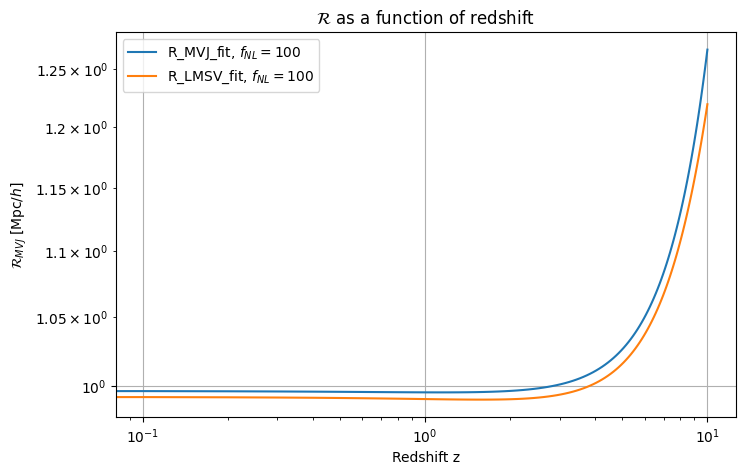

In [16]:
# plot R_MVJ for a range of z and M=10^{14}h^{-1}Msun
z_values = np.linspace(0, 10, 100)
M_halo = 1e10 * sh.Msun / sh.h  # Mass in h^{-1}Msun
#results_R_MVJ = [R_MVJ(z, f_NL=100, M=M_halo) for z in z_values]
#results_R_LMSV = [R_LMSV(z, f_NL=100, M=M_halo) for z in z_values]
results_R_MVJ_fit = [R_MVJ_fit(z, f_NL=100, M=M_halo) for z in z_values]
results_R_LMSV_fit = [R_LMSV_fit(z, f_NL=100, M=M_halo) for z in z_values]

plt.figure(figsize=(8, 5))
plt.loglog(z_values, results_R_MVJ_fit, label='R_MVJ_fit, $f_{NL}=100$')
plt.loglog(z_values, results_R_LMSV_fit, label='R_LMSV_fit, $f_{NL}=100$')
#plt.loglog(z_values, results_R_MVJ, '--', label='R_MVJ')
#plt.loglog(z_values, results_R_LMSV, '--', label='R_LMSV')
plt.xlabel('Redshift z')
plt.ylabel(r'$\mathcal{R}_{MVJ} \; [\mathrm{Mpc}/h]$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{R}$ as a function of redshift')
plt.show()

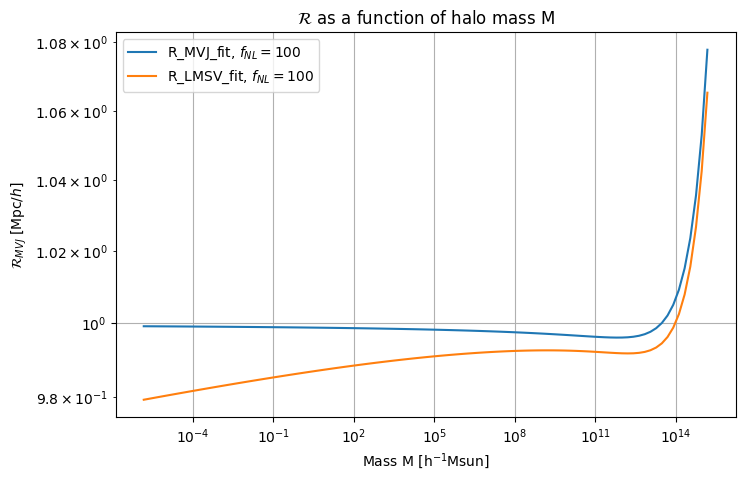

In [17]:
# plot R for a range of M and z=1
M_values = np.logspace(-6, 15, 100)
#results_R_MVJ_M = [R_MVJ(z=0.0, f_NL=100, M=_M*(sh.Msun / sh.h)) for _M in M_values]
#results_R_LMSV_M = [R_LMSV(z=0.0, f_NL=100, M=_M*(sh.Msun / sh.h)) for _M in M_values]
results_R_MVJ_fit_M = [R_MVJ_fit(z=0.0, f_NL=100, M=_M*(sh.Msun / sh.h)) for _M in M_values]
results_R_LMSV_fit_M = [R_LMSV_fit(z=0.0, f_NL=100, M=_M*(sh.Msun / sh.h)) for _M in M_values]

plt.figure(figsize=(8, 5))
plt.loglog(M_values*(sh.Msun / sh.h), results_R_MVJ_fit_M, label='R_MVJ_fit, $f_{NL}=100$')
plt.loglog(M_values*(sh.Msun / sh.h), results_R_LMSV_fit_M, label='R_LMSV_fit, $f_{NL}=100$')
#plt.loglog(M_values*(sh.Msun / sh.h), results_R_MVJ_M, label='R_MVJ')
#plt.loglog(M_values*(sh.Msun / sh.h), results_R_LMSV_M, label='R_LMSV')
plt.xlabel('Mass M [h$^{-1}$Msun]')
plt.ylabel(r'$\mathcal{R}_{MVJ} \; [\mathrm{Mpc}/h]$')
#plt.ylim(1, 1e7)
plt.legend()
plt.grid()
plt.title(r'$\mathcal{R}$ as a function of halo mass M')
plt.show()

In [18]:
R_MVJ_fit(z=0, f_NL=0, M=10e14 * sh.Msun)

1.0